In [2]:
# pip install lime shap

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as stat

from datetime import datetime
from interpret.perf import RegressionPerf
from itertools import chain
from numpy import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from random import sample, seed
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing 
## Some data extraction and preparation details not included due to privacy.

In [9]:
#Prep to start RUL modeling


scale= StandardScaler()

data = df.filter([rul_identifier, *rul_predictors, rul_label])

print("Number of Abandoned Wells: %5d" % data.shape[0])
print("Mean RUL: %2.2f" % stat.mean(df['REMAINING_USEFUL_LIFE']))

Number of Abandoned Wells: 209922
Mean RUL: 0.43


In [10]:
#Step 1: Standardize (data cleaned prior)
data[rul_predictors] = scale.fit_transform(data[rul_predictors])

In [11]:
# Separate features and target
X = data.drop(columns=['REMAINING_USEFUL_LIFE'])
y = data['REMAINING_USEFUL_LIFE']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
y_test

80743     0.3327
28222     0.2112
121798    0.3726
118113    0.5575
60879     0.0960
           ...  
9830      0.4203
43343     0.3003
134463    0.3841
170232    0.5428
71671     0.4859
Name: REMAINING_USEFUL_LIFE, Length: 41985, dtype: float64

In [13]:
X_test

array([[-0.60312421, -2.36358299, -0.05547141, ...,  0.00510377,
        -0.45601413,  0.37817776],
       [ 0.36021769, -0.83148146, -0.09178838, ...,  1.06058713,
         1.07246541,  1.51751197],
       [-0.14288404, -1.60403606, -0.09178838, ...,  0.84984714,
         0.76937117, -0.71996055],
       ...,
       [ 0.05408655,  0.8011959 , -0.09178838, ...,  1.55488982,
         1.82174559,  1.99739715],
       [ 0.81708672,  0.67460474, -0.09058288, ...,  0.82874342,
         0.74985866,  1.27285229],
       [-0.83155872,  0.6366274 , -0.02315963, ..., -1.08723681,
        -1.25299154, -0.71996055]])

In [20]:
y_train

107684    0.8148
162990    0.8183
142823    0.9430
142293    0.7499
9908      0.0079
           ...  
119879    0.3871
103694    0.2406
131932    0.4271
146867    0.2474
121958    0.3258
Name: REMAINING_USEFUL_LIFE, Length: 167937, dtype: float64

# Blueprints
## Interpretability of Explanations and Faithfulness of Explanability Model


1. Parsimony: 
Number of attributes with non zero weights.Max value is the total number of attributes used in the model. A more persimonious model (with a low value of parsimony) is preferred.

2. Functional Complexity FC: 
A low value should mean that the model does not depend on a particular feature(in the original paper the entire attribute type is considered unimportant to the prediction, i.e: FC is calculated for an entire attribute type) for the prediction
 how you can implement this:

Permute each feature individually and compute the model's predictions.
Compare the predictions with the original predictions using a suitable metric.
We can use the mean squared error (MSE) between the original and permuted predictions as a measure of the dependency of the model on each feature. The higher the MSE, the more the model depends on that feature. ( Original paper checks how many changed predictions when permuting the attribute, because with to many collerated features that can be used interchangeably the effect may not reflect in MSE)

3. Importance Ranking Correlation IRC:
how faithful the importance ranking of the explainablity model is to the ranking made by the permutation attribute importance(PI), note the PI isliterally how FC is implemented in this study
The value is quantified using  the non-parametric Spearman's corellation coefficient which ranges [-1,1]. +1 is a perfectly faithful model, decrease to 0 reflects decrease in faithfulness. A negative value is a negative rank association between the 2 importance weights.

4. Level of Disagreenment LOD: 
This metric is model-dependent,computes the percentage of similar predictions between the blackbox model and the explainability model (original paper modeified this to check the whether the PI and prediction model focus on the same attribute type, This is irrelevant so will stick to the original definition). question what is the xplainability model in this context

Imlementing LOD by comparing the percentage of similar preduictions between a blackbox model and an explainability model(as per definition in the paper). Here a transparent model (linear regression) is used as the explainabilty model. In my opinion should be the same model as a blackbox then the same model implemented with in built explainability.

To implement this metric, we need to:
1. Generate predictions from both the black-box model and the explainability model.
2. Compare the predictions to determine the percentage of similar predictions.

In this code:

The calculate_lod function compares the predictions of the black-box model (black_box_model) and the explainability model (explainability_model) and computes the percentage of similar predictions.
The Faithfulness class includes this method to calculate LOD using an explainability model.
You need to pass an explainability model (a simpler interpretable model) and the dataset X to the calculate_lod method of the Faithfulness class to compute the LOD metric.

In [21]:
import random
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import math

def calculate_parsimony(xai_importances):
    return (xai_importances > 0).sum()

def calculate_functional_complexity(model, X):
    n_samples, n_features = X.shape
    original_predictions = model.predict(X)
    
    change_counts = []
    for i in range(n_features):
        permuted_X = X.copy()
        permuted_X.iloc[:, i] = np.random.permutation(permuted_X.iloc[:, i])
        permuted_predictions = model.predict(permuted_X)
        
        # Count the number of predictions that changed
        changes = np.sum(original_predictions != permuted_predictions)
        change_counts.append(changes/X_test_df.shape[0])
    
    return change_counts

def calculate_irc(perm_importances, xai_importances):
    coef, _ = spearmanr(perm_importances, xai_importances)
    return coef

def calculate_lod(perm_top_10, xai_top_10):
    return distance.euclidean(perm_top_10, xai_top_10)


class Faithfulness():
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
    
    def calculate(self, xai_importances=None, model_explainer=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method in ['RF', 'XGB']:
            sample = shap.sample(self.dt_train_named_original, 1000)
            explainer = shap.TreeExplainer(self.cls, sample)
            shap_values = explainer.shap_values(sample, check_additivity=False)
            if self.cls_method == 'XGB':
                vals = np.abs(shap_values).mean(0)
            else:
                vals = np.abs(shap_values[0]).mean(0)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = vals
        
        elif self.cls_method == 'LR':
            coeffs = np.abs(self.cls.coef_).flatten()
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            
#             print(f"Length of coefficients: {len(coeffs)}")
#             print(f"Number of features: {len(self.dt_train_named_original.columns)}")
            
            xai_importances['coefficients'] = coeffs
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, p = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        return calculate_functional_complexity(self.cls, self.dt_train_named_original)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self):
        perm_top_10 = np.argsort(self.model_effects)[-10:]
        xai_top_10 = np.argsort(self.calculate()[1]['coefficients'])[-10:]
        return calculate_lod(perm_top_10, xai_top_10)


# Train and evaluate models
# ML: LR and XGB
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Train models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Dummy model effects (for illustration)
model_effects = np.random.rand(X_test.shape[1])

X_test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X.shape[1])])

# Faithfulness calculations
faithfulness_lr = Faithfulness('LR', X_test_df, model_effects, lr_model)
coef_lr, resulting_frame_lr = faithfulness_lr.calculate()
parsimony_lr = faithfulness_lr.calculate_parsimony()
functional_complexity_lr = faithfulness_lr.calculate_functional_complexity()
irc_lr = faithfulness_lr.calculate_irc()
lod_lr = faithfulness_lr.calculate_lod()

faithfulness_xgb = Faithfulness('XGB', X_test_df, model_effects, xgb_model)
coef_xgb, resulting_frame_xgb = faithfulness_xgb.calculate()
parsimony_xgb = faithfulness_xgb.calculate_parsimony()
functional_complexity_xgb = faithfulness_xgb.calculate_functional_complexity()
irc_xgb = faithfulness_xgb.calculate_irc()
lod_xgb = faithfulness_xgb.calculate_lod()

epsilon = 1e-10  # or a larger value depending on the scale of your data

# Predict and compute MSE for Linear Regression
lr_predictions = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, lr_predictions)
mape_lr = mean_absolute_percentage_error(y_test + epsilon, lr_predictions) * 100  # To express as a percentage


# Predict and compute MSE for XGBoost
xgb_predictions = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_predictions)
mape_xgb = mean_absolute_percentage_error(y_test + epsilon, xgb_predictions) * 100

# Output results
print(f'Linear Regression Parsimony: {parsimony_lr}')
print(f'Linear Regression Functional Complexity: {functional_complexity_lr}')
print(f'Linear Regression IRC: {irc_lr}')
print(f'Linear Regression LOD@10: {lod_lr}')
print(f'Linear Regression MSE: {mse_lr}')
print(f'Linear Regression MAPE: {mape_lr}')

print(f'XGBoost Parsimony: {parsimony_xgb}')
print(f'XGBoost Functional Complexity: {functional_complexity_xgb}')
print(f'XGBoost IRC: {irc_xgb}')
print(f'XGBoost LOD@10: {lod_xgb}')
print(f'XGBoost MSE: {mse_xgb}')
print(f'XGBoost MAPE: {mape_xgb}')




Linear Regression Parsimony: 47
Linear Regression Functional Complexity: [0.9968560200071455, 0.9575800881267119, 0.5182088841252829, 0.8806716684530189, 0.9928784089555793, 0.9645111349291413, 0.9159699892818864, 0.9560557341907824, 0.9989520066690485, 0.4386566630939621, 0.12423484577825414, 0.4749553411932833, 0.992282958199357, 0.9915922353221388, 0.6325592473502442, 0.1564606407050137, 0.15391211146838157, 0.15205430510896747, 0.15741336191496963, 0.00976539240204835, 0.0210551387400262, 0.0210551387400262, 0.9749910682386567, 0.9952363939502203, 0.9959747528879361, 0.9961652971299274, 0.30484696915565085, 0.9963558413719186, 0.9948076694057402, 0.9954507562224604, 0.9505537692032869, 0.9894247945694891, 0.9913778730498988, 0.3053709658211266, 0.9766345123258307, 0.9957603906156961, 0.9475526973919257, 0.9963558413719186, 0.9823746576158152, 0.24604025247112063, 0.6662617601524354, 0.5940454924377754, 0.9958556627366917, 0.9961652971299274, 0.8313921638680482, 0.9958080266761938, 

In [57]:
X_test_df.shape[0]

209977

In [21]:
# trial implementation for LOD

import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error

def calculate_parsimony(xai_importances):
    return (xai_importances > 0).sum()

def calculate_functional_complexity(model, X):
    n_samples, n_features = X.shape
    original_predictions = model.predict(X)
    
    change_counts = []
    for i in range(n_features):
        permuted_X = X.copy()
        permuted_X.iloc[:, i] = np.random.permutation(permuted_X.iloc[:, i])
        permuted_predictions = model.predict(permuted_X)
        
        # Count the number of predictions that changed
        changes = np.sum(original_predictions != permuted_predictions)
        change_counts.append(changes)
    
    return change_counts

def calculate_irc(perm_importances, xai_importances):
    coef, _ = spearmanr(perm_importances, xai_importances)
    return coef

def calculate_lod(blackbox_model, shap_values, X):
    blackbox_predictions = blackbox_model.predict(X)
    
    # Ensure blackbox_labels is a 1-dimensional array
    blackbox_labels = np.round(blackbox_predictions).astype(int)
    
    # Flatten shap_values if it's multi-dimensional
    if len(shap_values.shape) > 1:
        shap_values = np.round(shap_values).astype(int)
        shap_labels = np.argmax(shap_values, axis=1)  # Assuming multi-class classification
    else:
        shap_labels = np.round(shap_values).astype(int)
    
    print(f"Blackbox labels: {blackbox_labels}")
    print(f"SHAP labels: {shap_labels}")
    
    # Calculate percentage of matching labels
    matching_labels = (blackbox_labels == shap_labels).sum()
    total_labels = len(blackbox_labels)
    
    lod = 100 * (matching_labels / total_labels)
    return lod



class Faithfulness:
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
    
    def calculate(self, xai_importances=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method == 'LR':
            explainer = shap.LinearExplainer(self.cls, self.dt_train_named_original)
            shap_values = explainer.shap_values(self.dt_train_named_original)
            vals = np.abs(shap_values).mean(0)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = vals
        
        elif self.cls_method == 'XGB':
            sample = shap.sample(self.dt_train_named_original, 1000)
            explainer = shap.TreeExplainer(self.cls, sample)
            shap_values = explainer.shap_values(sample, check_additivity=False)
            vals = np.abs(shap_values).mean(0)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = vals
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, p = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        return calculate_functional_complexity(self.cls, self.dt_train_named_original)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self):
        if self.cls_method == 'LR':
            shap_explainer = shap.LinearExplainer(self.cls, self.dt_train_named_original)
        elif self.cls_method == 'XGB':
            sample = shap.sample(self.dt_train_named_original, 1000)
            shap_explainer = shap.TreeExplainer(self.cls, sample)
        
        shap_values = shap_explainer.shap_values(self.dt_train_named_original)
        return calculate_lod(self.cls, shap_values, self.dt_train_named_original)

# Example usage:

# Train and evaluate models
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Train models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Dummy model effects (for illustration)
model_effects = np.random.rand(X_train.shape[1])

# Faithfulness calculations
faithfulness_lr = Faithfulness('LR', pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])]), model_effects, lr_model)
coef_lr, resulting_frame_lr = faithfulness_lr.calculate()
parsimony_lr = faithfulness_lr.calculate_parsimony()
irc_lr = faithfulness_lr.calculate_irc()
lod_lr = faithfulness_lr.calculate_lod()

faithfulness_xgb = Faithfulness('XGB', pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])]), model_effects, xgb_model)
coef_xgb, resulting_frame_xgb = faithfulness_xgb.calculate()
parsimony_xgb = faithfulness_xgb.calculate_parsimony()
irc_xgb = faithfulness_xgb.calculate_irc()
lod_xgb = faithfulness_xgb.calculate_lod()

# Output results
print(f'Linear Regression Parsimony: {parsimony_lr}')
print(f'Linear Regression IRC: {irc_lr}')
print(f'Linear Regression LOD: {lod_lr}')

print(f'XGBoost Parsimony: {parsimony_xgb}')
print(f'XGBoost IRC: {irc_xgb}')
print(f'XGBoost LOD: {lod_xgb}')


Blackbox labels: [ -61  190  376   20  132 -150  -63  -58 -100   12  -47 -354  111 -180
   15 -128 -407  251    2  187  -98  466   64 -157 -164 -282  -50  -95
  166 -199  367 -204  154  -60   28 -294 -188  295  -12   21  129   17
  -38 -144   39  -39  179   62   -2  197   77    0   73   16   51  264
 -356  -60 -161   38   68   73   40  -48  416  149 -119  232 -114  207
 -105 -160   84  188  122  128 -262  -77  -61  200]
SHAP labels: [6 4 4 3 4 5 9 6 3 4 6 2 6 5 5 4 7 3 5 3 9 6 3 3 4 1 9 3 9 7 6 3 4 9 5 5 5
 3 4 5 4 5 4 6 4 0 4 9 6 5 4 4 4 4 1 4 6 1 1 3 4 1 6 5 6 5 0 4 1 9 9 4 9 4
 5 4 5 6 1 9]
Blackbox labels: [ -61  190  377   20  132 -150  -63  -58 -100   12  -47 -354  111 -180
   15 -128 -407  251    2  187  -98  466   64 -157 -164 -282  -50  -95
  166 -199  367 -204  154  -60   27 -294 -188  295  -12   21  129   17
  -38 -144   39  -39  179   62   -2  197   77    0   73   16   51  264
 -356  -61 -161   38   68   73   40  -48  416  149 -119  232 -114  207
 -105 -160   84  189  122  

In [19]:
# # This uses MSE for FC


# # In this updated code, the calculate_functional_complexity function permutes each feature one at a time 
# # and measures the change in the model's predictions using the mean squared error (MSE). 
# # The number of changed predictions seems to be the same for every feature in the previous implementation so 
# # ??? How to combine the two or which one to use (MSE or count changed predictions)
# # This approach allows you to calculate FC for each individual feature. 
# # The results will help you understand how dependent your model is on each feature.

# import random
# import shap
# import pandas as pd
# import numpy as np
# from scipy.stats import spearmanr
# from scipy.spatial import distance
# from sklearn.metrics import mean_squared_error
# import math

# def calculate_parsimony(xai_importances):
#     return (xai_importances > 0).sum()

# def calculate_functional_complexity(model, X, model_effects):
#     n_samples, n_features = X.shape
#     original_predictions = model.predict(X)
    
#     fc_scores = []
#     for i in range(n_features):
#         permuted_X = X.copy()
#         permuted_X.iloc[:, i] = np.random.permutation(permuted_X.iloc[:, i])
#         permuted_predictions = model.predict(permuted_X)
        
#         mse = mean_squared_error(original_predictions, permuted_predictions)
#         fc_scores.append(mse)
    
#     return fc_scores

# def calculate_irc(perm_importances, xai_importances):
#     coef, _ = spearmanr(perm_importances, xai_importances)
#     return coef

# def calculate_lod(perm_top_10, xai_top_10):
#     return distance.euclidean(perm_top_10, xai_top_10)

# class Faithfulness():
#     def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None):
#         self.cls = cls
#         self.cls_method = cls_method
#         self.dt_train_named_original = dt_train_named_original
#         self.model_effects = model_effects
    
#     def calculate(self, xai_importances=None, model_explainer=None):
#         feature_importance = pd.DataFrame()
#         feature_importance['variable'] = self.dt_train_named_original.columns
#         perturbation_importance = self.model_effects
#         feature_importance['importances'] = perturbation_importance
        
#         if self.cls_method in ['RF', 'XGB']:
#             sample = shap.sample(self.dt_train_named_original, 1000)
#             explainer = shap.TreeExplainer(self.cls, sample)
#             shap_values = explainer.shap_values(sample, check_additivity=False)
#             if self.cls_method == 'XGB':
#                 vals = np.abs(shap_values).mean(0)
#             else:
#                 vals = np.abs(shap_values[0]).mean(0)
            
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = vals
        
#         elif self.cls_method == 'LR':
#             coeffs = np.abs(self.cls.coef_).flatten()
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = coeffs
        
#         elif self.cls_method == 'GLRM':
#             feature_importances = []
#             for i in range(len(self.dt_train_named_original.columns)):
#                 feature_importance_value = abs(model_explainer[(model_explainer['rule'].str.contains(self.dt_train_named_original.columns[i]))]['coefficient']).sum()
#                 feature_importances.append(feature_importance_value)
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = feature_importances
        
#         resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
#         resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
#         coef, p = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
#         return coef, resulting_frame
    
#     def calculate_parsimony(self):
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_parsimony(xai_importances)
    
#     def calculate_functional_complexity(self):
#         return calculate_functional_complexity(self.cls, self.dt_train_named_original, self.model_effects)
    
#     def calculate_irc(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_irc(perm_importances, xai_importances)
    
#     def calculate_lod(self):
#         perm_top_10 = np.argsort(self.model_effects)[-10:]
#         xai_top_10 = np.argsort(self.calculate()[1]['coefficients'])[-10:]
#         return calculate_lod(perm_top_10, xai_top_10)

# # Example usage:

# # Train and evaluate models
# # ML: LR and XGB
# from sklearn.linear_model import LinearRegression
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# import xgboost as xgb
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# xgb_model.fit(X_train, y_train)

# # Prepare dummy data for Faithfulness calculation
# model_effects = np.random.rand(X_train.shape[1])

# # Calculate faithfulness for Linear Regression model
# faithfulness_lr = Faithfulness('LR', pd.DataFrame(X_train, columns=X.columns), model_effects, lr_model)
# coef_lr, resulting_frame_lr = faithfulness_lr.calculate()

# # Calculate faithfulness for XGBoost model
# faithfulness_xgb = Faithfulness('XGB', pd.DataFrame(X_train, columns=X.columns), model_effects, xgb_model)
# coef_xgb, resulting_frame_xgb = faithfulness_xgb.calculate()

# # Calculate parsimony, functional complexity, IRC, and LOD for LR model
# parsimony_lr = faithfulness_lr.calculate_parsimony()
# functional_complexity_lr = faithfulness_lr.calculate_functional_complexity()
# irc_lr = faithfulness_lr.calculate_irc()
# lod_lr = faithfulness_lr.calculate_lod()

# print(f'Linear Regression Parsimony: {parsimony_lr}')
# print(f'Linear Regression Functional Complexity: {functional_complexity_lr}')
# print(f'Linear Regression IRC: {irc_lr}')
# print(f'Linear Regression LOD@10: {lod_lr}')


Linear Regression Parsimony: 47
Linear Regression Functional Complexity: [0.012231809, 0.0026282493, 1.3595969e-05, 4.7024652e-05, 0.0006289305, 0.040517285, 0.00024014736, 0.0774652, 6.353478e-05, 0.0016793212, 2.2068654e-08, 4.3774207e-06, 0.0006975254, 0.00042716143, 2.6201442e-06, 0.0020366327, 6.735168e-05, 0.023663493, 0.017265571, 8.650937e-05, 0.000108897955, 0.00038171353, 0.0005529458, 0.00020314341, 0.0001811734, 0.0006264118, 5.516338e-05, 6.807291e-05, 0.00073559873, 0.0003719519, 0.0001017126, 0.0012664973, 0.00017807075, 2.4173449e-05, 6.478361e-05, 0.0008541762, 5.4821172e-05, 0.0011757526, 0.0006254373, 3.4597982e-05, 4.0284493e-05, 0.0064628692, 9.909892e-07, 0.00090377184, 7.692305e-05, 0.0012382371, 0.003056675]
Linear Regression IRC: -0.001156336725254394
Linear Regression LOD@10: 52.09606511052442


Below is the implementation of the Faithfulness class, adapted for CNNs and LSTMs using PyTorch. We will use gradient-based feature importance (using Integrated Gradients) instead of SHAP values for these models.

In [15]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from scipy.stats import spearmanr
# from scipy.spatial import distance
# from torch.utils.data import DataLoader, TensorDataset

# # Function to calculate parsimony
# def calculate_parsimony(xai_importances):
#     return (xai_importances > 0).sum()

# # Function to calculate functional complexity
# def calculate_functional_complexity(model, X):
#     n_samples, n_features = X.shape
#     model.eval()
#     with torch.no_grad():
#         original_predictions = model(X).cpu().numpy()
    
#     change_counts = []
#     for i in range(n_features):
#         permuted_X = X.clone()
#         permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
#         with torch.no_grad():
#             permuted_predictions = model(permuted_X).cpu().numpy()
        
#         # Count the number of predictions that changed
#         changes = np.sum(original_predictions != permuted_predictions)
#         change_counts.append(changes)
    
#     return change_counts

# # Function to calculate IRC
# def calculate_irc(perm_importances, xai_importances):
#     coef, _ = spearmanr(perm_importances, xai_importances)
#     return coef

# # Function to calculate LOD
# def calculate_lod(perm_top_10, xai_top_10):
#     return distance.euclidean(perm_top_10, xai_top_10)

# class IntegratedGradients:
#     def __init__(self, model, device):
#         self.model = model
#         self.device = device

#     def generate_baseline(self, X):
#         return torch.zeros_like(X)

#     def interpolate(self, X, baseline, steps=50):
#         alphas = torch.linspace(0, 1, steps).view(steps, 1, 1).to(self.device)
#         delta = X - baseline
#         interpolated = baseline + alphas * delta
#         return interpolated

#     def compute_gradients(self, inputs, targets):
#         self.model.eval()
#         inputs = inputs.requires_grad_()
#         outputs = self.model(inputs)
#         loss = nn.MSELoss()(outputs, targets)
#         loss.backward()
#         return inputs.grad

#     def calculate_importance(self, X, y, steps=50):
#         X = X.to(self.device)
#         y = y.to(self.device)
#         baseline = self.generate_baseline(X).to(self.device)
#         interpolated = self.interpolate(X, baseline, steps=steps)
#         integrated_gradients = torch.zeros_like(X).to(self.device)

#         for i in range(steps):
#             grads = self.compute_gradients(interpolated[i], y)
#             integrated_gradients += grads / steps
        
#         return integrated_gradients.abs().mean(dim=0).cpu().numpy()

# class Faithfulness():
#     def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
#         self.cls = cls
#         self.cls_method = cls_method
#         self.dt_train_named_original = dt_train_named_original
#         self.model_effects = model_effects
#         self.device = device
    
#     def calculate(self, xai_importances=None, model_explainer=None):
#         feature_importance = pd.DataFrame()
#         feature_importance['variable'] = self.dt_train_named_original.columns
#         perturbation_importance = self.model_effects
#         feature_importance['importances'] = perturbation_importance
        
#         if self.cls_method in ['CNN', 'LSTM']:
#             integrated_gradients = IntegratedGradients(self.cls, self.device)
#             X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#             y_tensor = torch.tensor(self.model_effects, dtype=torch.float32).to(self.device)
#             importances = integrated_gradients.calculate_importance(X_tensor, y_tensor)
            
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = importances.flatten()
        
#         resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
#         resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
#         coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
#         return coef, resulting_frame
    
#     def calculate_parsimony(self):
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_parsimony(xai_importances)
    
#     def calculate_functional_complexity(self):
#         X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#         return calculate_functional_complexity(self.cls, X_tensor)
    
#     def calculate_irc(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_irc(perm_importances, xai_importances)
    
#     def calculate_lod(self):
#         perm_top_10 = np.argsort(self.model_effects)[-10:]
#         xai_top_10 = np.argsort(self.calculate()[1]['coefficients'])[-10:]
#         return calculate_lod(perm_top_10, xai_top_10)

# # Example usage:

# # Generate synthetic data
# n_samples, n_features = 1000, 20
# # X = np.random.rand(n_samples, n_features).astype(np.float32)
# # y = np.random.rand(n_samples).astype(np.float32)
# # X_train, y_train = torch.tensor(X), torch.tensor(y)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Define a simple CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * n_features, 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x.unsqueeze(1)))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Train CNN model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cnn_model = SimpleCNN().to(device)
# optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# cnn_model.train()
# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = cnn_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Dummy model effects (for illustration)
# model_effects = np.random.rand(X_train.shape[1])

# # Faithfulness calculations for CNN
# X_train_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
# faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
# coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
# parsimony_cnn = faithfulness_cnn.calculate_parsimony()
# functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
# irc_cnn = faithfulness_cnn.calculate_irc()
# lod_cnn = faithfulness_cnn.calculate_lod()

# print(f'CNN Parsimony: {parsimony_cnn}')
# print(f'CNN Functional Complexity: {functional_complexity_cnn}')
# print(f'CNN IRC: {irc_cnn}')
# print(f'CNN LOD@10: {lod_cnn}')

# # Define a simple LSTM model
# class SimpleLSTM(nn.Module):
#     def __init__(self):
#         super(SimpleLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(50, 1)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), 50).to(device)
#         c0 = torch.zeros(1, x.size(0), 50).to(device)
#         out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Train LSTM model
# lstm_model = SimpleLSTM().to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# lstm_model.train()
# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = lstm_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Faithfulness calculations for LSTM
# faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
# coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
# parsimony_lstm = faithfulness_lstm.calculate_parsimony()
# functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
# irc_lstm = faithfulness_lstm.calculate_irc()
# lod_lstm = faithfulness_lstm.calculate_lod()

# print(f'LSTM Parsimony: {parsimony_lstm}')
# print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
# print(f'LSTM IRC: {irc_lstm}')
# print(f'LSTM LOD@10: {lod_lstm}')


In [14]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from scipy.stats import spearmanr
# from scipy.spatial import distance
# from torch.utils.data import DataLoader, TensorDataset

# # Function to calculate parsimony
# def calculate_parsimony(xai_importances):
#     return (xai_importances > 0).sum()

# # Function to calculate functional complexity
# def calculate_functional_complexity(model, X):
#     n_samples, n_features = X.shape
#     model.eval()
#     with torch.no_grad():
#         original_predictions = model(X).cpu().numpy()
    
#     change_counts = []
#     for i in range(n_features):
#         permuted_X = X.clone()
#         permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
#         with torch.no_grad():
#             permuted_predictions = model(permuted_X).cpu().numpy()
        
#         # Count the number of predictions that changed
#         changes = np.sum(original_predictions != permuted_predictions)
#         change_counts.append(changes)
    
#     return change_counts

# # Function to calculate IRC
# def calculate_irc(perm_importances, xai_importances):
#     coef, _ = spearmanr(perm_importances, xai_importances)
#     return coef

# # Function to calculate LOD
# def calculate_lod(perm_top_10, xai_top_10):
#     return distance.euclidean(perm_top_10, xai_top_10)

# class IntegratedGradients:
#     def __init__(self, model, device):
#         self.model = model
#         self.device = device

#     def generate_baseline(self, X):
#         return torch.zeros_like(X)

#     def interpolate(self, X, baseline, steps=50):
#         alphas = torch.linspace(0, 1, steps).view(steps, 1, 1).to(self.device)
#         delta = X - baseline
#         interpolated = baseline + alphas * delta
#         return interpolated

#     def compute_gradients(self, inputs, targets):
#         self.model.eval()
#         inputs = inputs.requires_grad_()
#         outputs = self.model(inputs)
#         loss = nn.MSELoss()(outputs, targets)
#         loss.backward()
#         return inputs.grad

#     def calculate_importance(self, X, y, steps=50):
#         X = X.to(self.device)
#         y = y.to(self.device)
#         baseline = self.generate_baseline(X).to(self.device)
#         interpolated = self.interpolate(X, baseline, steps=steps)
#         integrated_gradients = torch.zeros_like(X).to(self.device)

#         for i in range(steps):
#             grads = self.compute_gradients(interpolated[i], y)
#             integrated_gradients += grads / steps
        
#         return integrated_gradients.abs().mean(dim=0).cpu().numpy()

# class Faithfulness():
#     def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
#         self.cls = cls
#         self.cls_method = cls_method
#         self.dt_train_named_original = dt_train_named_original
#         self.model_effects = model_effects
#         self.device = device
    
#     def calculate(self, xai_importances=None, model_explainer=None):
#         feature_importance = pd.DataFrame()
#         feature_importance['variable'] = self.dt_train_named_original.columns
#         perturbation_importance = self.model_effects
#         feature_importance['importances'] = perturbation_importance
        
#         if self.cls_method in ['CNN', 'LSTM']:
#             integrated_gradients = IntegratedGradients(self.cls, self.device)
#             X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#             y_tensor = torch.tensor(self.model_effects, dtype=torch.float32).to(self.device)
#             importances = integrated_gradients.calculate_importance(X_tensor, y_tensor)
            
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = importances.flatten()
        
#         resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
#         resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
#         coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
#         return coef, resulting_frame
    
#     def calculate_parsimony(self):
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_parsimony(xai_importances)
    
#     def calculate_functional_complexity(self):
#         X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#         return calculate_functional_complexity(self.cls, X_tensor)
    
#     def calculate_irc(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_irc(perm_importances, xai_importances)
    
#     def calculate_lod(self):
#         perm_top_10 = np.argsort(self.model_effects)[-10:]
#         xai_top_10 = np.argsort(self.calculate()[1]['coefficients'])[-10:]
#         return calculate_lod(perm_top_10, xai_top_10)

# # Example usage:

# # Convert to PyTorch tensors

# X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
# y_train = torch.from_numpy(np.array(y_train).astype(np.float32))

# # X_train = torch.tensor(X)
# # y_train = torch.tensor(y)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Define a simple CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x.unsqueeze(1)))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Train CNN model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cnn_model = SimpleCNN().to(device)
# optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# cnn_model.train()
# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = cnn_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Dummy model effects (for illustration)
# model_effects = np.random.rand(X_train.shape[1])

# # Faithfulness calculations for CNN
# X_train_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
# faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
# coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
# parsimony_cnn = faithfulness_cnn.calculate_parsimony()
# functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
# irc_cnn = faithfulness_cnn.calculate_irc()
# lod_cnn = faithfulness_cnn.calculate_lod()

# print(f'CNN Parsimony: {parsimony_cnn}')
# print(f'CNN Functional Complexity: {functional_complexity_cnn}')
# print(f'CNN IRC: {irc_cnn}')
# print(f'CNN LOD@10: {lod_cnn}')

# # Define a simple LSTM model
# class SimpleLSTM(nn.Module):
#     def __init__(self):
#         super(SimpleLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(50, 1)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), 50).to(device)
#         c0 = torch.zeros(1, x.size(0), 50).to(device)
#         out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Train LSTM model
# lstm_model = SimpleLSTM().to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()



In [66]:
# # uses integrated gradients as explainer and MSE for LOD

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from scipy.stats import spearmanr
# from scipy.spatial import distance
# from torch.utils.data import DataLoader, TensorDataset

# # Function to calculate parsimony
# def calculate_parsimony(xai_importances):
#     return (xai_importances > 0).sum()

# # Function to calculate functional complexity
# def calculate_functional_complexity(model, X):
#     n_samples, n_features = X.shape
#     model.eval()
#     with torch.no_grad():
#         original_predictions = model(X).cpu().numpy()
    
#     mse_changes = []
#     for i in range(n_features):
#         permuted_X = X.clone()
#         permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
#         with torch.no_grad():
#             permuted_predictions = model(permuted_X).cpu().numpy()
        
#         # Calculate the mean squared error between original and permuted predictions
#         mse = mean_squared_error(original_predictions, permuted_predictions)
#         mse_changes.append(mse)
    
#     return mse_changes

# # Function to calculate IRC
# def calculate_irc(perm_importances, xai_importances):
#     coef, _ = spearmanr(perm_importances, xai_importances)
#     return coef

# # Function to calculate LOD
# def calculate_lod(perm_importances, xai_importances):
#     return distance.euclidean(perm_importances, xai_importances)

# class IntegratedGradients:
#     def __init__(self, model, device):
#         self.model = model
#         self.device = device

#     def generate_baseline(self, X):
#         return torch.zeros_like(X)

#     def interpolate(self, X, baseline, steps=50):
#         alphas = torch.linspace(0, 1, steps).view(steps, 1, 1).to(self.device)
#         delta = X - baseline
#         interpolated = baseline + alphas * delta
#         return interpolated

#     def compute_gradients(self, inputs, targets):
#         self.model.eval()
#         inputs = inputs.requires_grad_()
#         outputs = self.model(inputs)
#         loss = nn.MSELoss()(outputs, targets)
#         loss.backward()
#         return inputs.grad

#     def calculate_importance(self, X, y, steps=50):
#         X = X.to(self.device)
#         y = y.to(self.device)
#         baseline = self.generate_baseline(X).to(self.device)
#         interpolated = self.interpolate(X, baseline, steps=steps)
#         integrated_gradients = torch.zeros_like(X).to(self.device)

#         for i in range(steps):
#             grads = self.compute_gradients(interpolated[i], y)
#             integrated_gradients += grads / steps
        
#         return integrated_gradients.abs().mean(dim=0).cpu().numpy()

# class Faithfulness:
#     def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
#         self.cls = cls
#         self.cls_method = cls_method
#         self.dt_train_named_original = dt_train_named_original
#         self.model_effects = model_effects
#         self.device = device
    
#     def calculate(self, xai_importances=None, model_explainer=None):
#         feature_importance = pd.DataFrame()
#         feature_importance['variable'] = self.dt_train_named_original.columns
#         perturbation_importance = self.model_effects
#         feature_importance['importances'] = perturbation_importance
        
#         if self.cls_method in ['CNN', 'LSTM']:
#             integrated_gradients = IntegratedGradients(self.cls, self.device)
#             X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#             y_tensor = torch.tensor(self.model_effects, dtype=torch.float32).to(self.device)
#             importances = integrated_gradients.calculate_importance(X_tensor, y_tensor)
            
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = importances.flatten()
        
#         resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
#         resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
#         coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
#         return coef, resulting_frame
    
#     def calculate_parsimony(self):
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_parsimony(xai_importances)
    
#     def calculate_functional_complexity(self):
#         X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#         return calculate_functional_complexity(self.cls, X_tensor)
    
#     def calculate_irc(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_irc(perm_importances, xai_importances)
    
#     def calculate_lod(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_lod(perm_importances, xai_importances)

# # Example usage:

# # # Generate synthetic data for example
# # X_train = np.random.randn(1000, 20)
# # y_train = np.random.randn(1000)

# # Convert to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Define a simple CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x.unsqueeze(1)))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Train CNN model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cnn_model = SimpleCNN().to(device)
# optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# cnn_model.train()
# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = cnn_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Dummy model effects (for illustration)
# model_effects = np.random.rand(X_train.shape[1])

# # Faithfulness calculations for CNN
# X_train_df = pd.DataFrame(X_train.numpy(), columns=[f'feature_{i}' for i in range(X_train.shape[1])])
# faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
# coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
# parsimony_cnn = faithfulness_cnn.calculate_parsimony()
# functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
# irc_cnn = faithfulness_cnn.calculate_irc()
# lod_cnn = faithfulness_cnn.calculate_lod()

# print(f'CNN Parsimony: {parsimony_cnn}')
# print(f'CNN Functional Complexity: {functional_complexity_cnn}')
# print(f'CNN IRC: {irc_cnn}')
# print(f'CNN LOD: {lod_cnn}')

# # Define a simple LSTM model
# class SimpleLSTM(nn.Module):
#     def __init__(self):
#         super(SimpleLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(50, 1)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), 50).to(device)
#         c0 = torch.zeros(1, x.size(0), 50).to(device)
#         out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Train LSTM model
# lstm_model = SimpleLSTM().to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = lstm_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Faithfulness calculations for LSTM
# faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
# coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
# parsimony_lstm = faithfulness_lstm.calculate_parsimony()
# functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
# irc_lstm = faithfulness_lstm.calculate_irc()
# lod_lstm = faithfulness_lstm.calculate_lod()

# print(f'LSTM Parsimony: {parsimony_lstm}')
# print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
# print(f'LSTM IRC: {irc_lstm}')
# print(f'LSTM LOD: {lod_lstm}')


In [72]:
# uses integrated gradients as explainer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.spatial import distance
from torch.utils.data import DataLoader, TensorDataset

# Function to calculate parsimony
def calculate_parsimony(xai_importances):
    return (xai_importances > 0).sum()

# Function to calculate functional complexity
def calculate_functional_complexity(model, X):
    n_samples, n_features = X.shape
    model.eval()
    with torch.no_grad():
        original_predictions = model(X).cpu().numpy()

    changed_predictions_count = []
    for i in range(n_features):
        permuted_X = X.clone()
        permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
        with torch.no_grad():
            permuted_predictions = model(permuted_X).cpu().numpy()

        # Count the number of changed predictions
        changed_count = np.sum(original_predictions != permuted_predictions)
        changed_predictions_count.append(changed_count/X_test.shape[0])

    return changed_predictions_count


# Function to calculate IRC
def calculate_irc(perm_importances, xai_importances):
    coef, _ = spearmanr(perm_importances, xai_importances)
    return coef

# Function to calculate LOD
def calculate_lod(perm_importances, xai_importances):
    return distance.euclidean(perm_importances, xai_importances)

class IntegratedGradients:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def generate_baseline(self, X):
        return torch.zeros_like(X)

    def interpolate(self, X, baseline, steps=50):
        alphas = torch.linspace(0, 1, steps).view(steps, 1, 1).to(self.device)
        delta = X - baseline
        interpolated = baseline + alphas * delta
        return interpolated

    def compute_gradients(self, inputs, targets):
        self.model.eval()
        inputs = inputs.requires_grad_()
        outputs = self.model(inputs)
        loss = nn.MSELoss()(outputs, targets)
        loss.backward()
        return inputs.grad

    def calculate_importance(self, X, y, steps=50):
        X = X.to(self.device)
        y = y.to(self.device)
        baseline = self.generate_baseline(X).to(self.device)
        interpolated = self.interpolate(X, baseline, steps=steps)
        integrated_gradients = torch.zeros_like(X).to(self.device)

        for i in range(steps):
            grads = self.compute_gradients(interpolated[i], y)
            integrated_gradients += grads / steps
        
        return integrated_gradients.abs().mean(dim=0).cpu().numpy()

class Faithfulness:
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
        self.device = device
    
    def calculate(self, xai_importances=None, model_explainer=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method in ['CNN', 'LSTM']:
            integrated_gradients = IntegratedGradients(self.cls, self.device)
            X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
            y_tensor = torch.tensor(self.model_effects, dtype=torch.float32).to(self.device)
            importances = integrated_gradients.calculate_importance(X_tensor, y_tensor)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = importances.flatten()
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
        return calculate_functional_complexity(self.cls, X_tensor)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_lod(perm_importances, xai_importances)

# Example usage:

# Convert to PyTorch tensors
X_trainDL = torch.tensor(X_train, dtype=torch.float32)
y_trainDL = torch.tensor(y_train, dtype=torch.float32)
X_testDL = torch.tensor(X_test, dtype=torch.float32)
y_testDL = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


# Create DataLoader
train_dataset = TensorDataset(X_trainDL, y_trainDL)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train CNN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = SimpleCNN().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

cnn_model.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

# Dummy model effects (for illustration)
model_effects = np.random.rand(X_test.shape[1])

# Faithfulness calculations for CNN
X_train_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
parsimony_cnn = faithfulness_cnn.calculate_parsimony()
functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
irc_cnn = faithfulness_cnn.calculate_irc()
lod_cnn = faithfulness_cnn.calculate_lod()

print(f'CNN Parsimony: {parsimony_cnn}')
print(f'CNN Functional Complexity: {functional_complexity_cnn}')
print(f'CNN IRC: {irc_cnn}')
print(f'CNN LOD: {lod_cnn}')

cnn_model.eval()
with torch.no_grad():
    cnn_predictions = cnn_model(X_testDL.to(device)).cpu().numpy()
mse_cnn = mean_squared_error(y_test, cnn_predictions)
print(f'CNN MSE: {mse_cnn}')

# Define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 50).to(device)
        c0 = torch.zeros(1, x.size(0), 50).to(device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Train LSTM model
lstm_model = SimpleLSTM().to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(5):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = lstm_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

# Faithfulness calculations for LSTM
faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
parsimony_lstm = faithfulness_lstm.calculate_parsimony()
functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
irc_lstm = faithfulness_lstm.calculate_irc()
lod_lstm = faithfulness_lstm.calculate_lod()

print(f'LSTM Parsimony: {parsimony_lstm}')
print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
print(f'LSTM IRC: {irc_lstm}')
print(f'LSTM LOD: {lod_lstm}')

      # Compute and print MSE for LSTM model
lstm_model.eval()
with torch.no_grad():
    lstm_predictions = lstm_model(X_testDL.to(device)).cpu().numpy()
mse_lstm = mean_squared_error(y_test, lstm_predictions)
print(f'LSTM MSE: {mse_lstm}')


CNN Parsimony: 47
CNN Functional Complexity: [0.9967139727593104, 0.955567196875893, 0.5186446328221735, 0.8783693685112868, 0.9919754262310696, 0.9653538432231641, 0.917587389275169, 0.9549004667111154, 0.9986665396704448, 0.441637298790361, 0.12201162015430041, 0.4705686255833889, 0.9924516620630536, 0.9911420135250977, 0.6283931803028859, 0.1535384322316411, 0.1534193732736451, 0.1518239832364987, 0.1563006000571483, 0.009715210972473569, 0.02150204781407753, 0.02138298885608153, 0.9763548909419945, 0.9951423945137632, 0.9957376893037432, 0.9961424897609296, 0.3032193542242118, 0.9960472425945328, 0.992737403562244, 0.9942613582245928, 0.9488522716449186, 0.9903324126107248, 0.9909991427755024, 0.3024573768930374, 0.9776645394799505, 0.9927135917706448, 0.949138013144109, 0.9954043242213544, 0.9834031812553576, 0.24292789789503763, 0.6654681398228403, 0.5640060958186494, 0.9637108296028193, 0.9439470425754833, 0.8330317173064101, 0.996309172302124, 0.5953900371463949]
CNN IRC: -0.06

In [73]:
# uses SHAP as explainer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.spatial import distance
from torch.utils.data import DataLoader, TensorDataset
import shap

# Function to calculate parsimony
def calculate_parsimony(xai_importances):
    return (xai_importances > 0).sum()

# Function to calculate functional complexity
def calculate_functional_complexity(model, X):
    n_samples, n_features = X.shape
    model.eval()
    with torch.no_grad():
        original_predictions = model(X).cpu().numpy()

    changed_predictions_count = []
    for i in range(n_features):
        permuted_X = X.clone()
        permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
        with torch.no_grad():
            permuted_predictions = model(permuted_X).cpu().numpy()

        # Count the number of changed predictions
        changed_count = np.sum(original_predictions != permuted_predictions)
        changed_predictions_count.append(changed_count/X_test.shape[0])

    return changed_predictions_count

# Function to calculate IRC
def calculate_irc(perm_importances, xai_importances):
    coef, _ = spearmanr(perm_importances, xai_importances)
    return coef

# Function to calculate LOD
def calculate_lod(perm_importances, xai_importances):
    return distance.euclidean(perm_importances, xai_importances)

class ShapExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.explainer = shap.DeepExplainer(model, torch.zeros(1, X_train.shape[1]).to(device))

    def calculate_importance(self, X):
        X = X.to(self.device)
        shap_values = self.explainer.shap_values(X, check_additivity=False)
        return np.abs(shap_values).mean(axis=0)

class Faithfulness:
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
        self.device = device
    
    def calculate(self, xai_importances=None, model_explainer=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method in ['CNN', 'LSTM']:
            shap_explainer = ShapExplainer(self.cls, self.device)
            X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
            importances = shap_explainer.calculate_importance(X_tensor)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = importances.flatten()
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
        return calculate_functional_complexity(self.cls, X_tensor)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_lod(perm_importances, xai_importances)

# Example usage:



# # Convert to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Define a simple CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x.unsqueeze(1)))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Train CNN model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cnn_model = SimpleCNN().to(device)
# optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# cnn_model.train()
# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = cnn_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# # Dummy model effects (for illustration)
# model_effects = np.random.rand(X_test.shape[1])

# Faithfulness calculations for CNN
# X_train_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
parsimony_cnn = faithfulness_cnn.calculate_parsimony()
functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
irc_cnn = faithfulness_cnn.calculate_irc()
lod_cnn = faithfulness_cnn.calculate_lod()

print(f'CNN Parsimony: {parsimony_cnn}')
print(f'CNN Functional Complexity: {functional_complexity_cnn}')
print(f'CNN IRC: {irc_cnn}')
print(f'CNN LOD: {lod_cnn}')

# # Define a simple LSTM model
# class SimpleLSTM(nn.Module):
#     def __init__(self):
#         super(SimpleLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(50, 1)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), 50).to(device)
#         c0 = torch.zeros(1, x.size(0), 50).to(device)
#         out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Train LSTM model
# lstm_model = SimpleLSTM().to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# for epoch in range(5):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         predictions = lstm_model(X_batch)
#         loss = criterion(predictions.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()

# Faithfulness calculations for LSTM
faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
parsimony_lstm = faithfulness_lstm.calculate_parsimony()
functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
irc_lstm = faithfulness_lstm.calculate_irc()
lod_lstm = faithfulness_lstm.calculate_lod()

print(f'LSTM Parsimony: {parsimony_lstm}')
print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
print(f'LSTM IRC: {irc_lstm}')
print(f'LSTM LOD: {lod_lstm}')


CNN Parsimony: 47
CNN Functional Complexity: [0.9967615963425088, 0.9545671016287266, 0.5193589865701496, 0.8802743118392228, 0.9919992380226689, 0.9637584531860177, 0.9177540718163635, 0.9569959043718449, 0.9988570340032384, 0.44156586341556336, 0.12258310315268121, 0.4720925802457377, 0.9929040861034384, 0.9925945328126489, 0.6277026383465092, 0.1533241261072483, 0.1542765977712163, 0.15258596056767312, 0.15451471568720831, 0.009715210972473569, 0.021525859605676732, 0.02150204781407753, 0.9775692923135537, 0.9955471949709496, 0.995713877512144, 0.9951900180969616, 0.30302885989141826, 0.9962377369273264, 0.992737403562244, 0.9937851223926089, 0.947352128774169, 0.9906895894847129, 0.9912134488998953, 0.30302885989141826, 0.9771406800647681, 0.9925707210210496, 0.9473997523573674, 0.9963806076769216, 0.9818077912182113, 0.24338032193542242, 0.6677540718163635, 0.5669825697685494, 0.9629250404800457, 0.9418992284979522, 0.8339127535955805, 0.9954995713877512, 0.5968425564339461]
CNN I

In [75]:


# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from scipy.stats import spearmanr
# from torch.utils.data import DataLoader, TensorDataset
# import shap

# # Function to calculate parsimony
# def calculate_parsimony(xai_importances):
#     return (xai_importances > 0).sum()

# # Function to calculate functional complexity
# def calculate_functional_complexity(model, X):
#     n_samples, n_features = X.shape
#     model.eval()
#     with torch.no_grad():
#         original_predictions = model(X).cpu().numpy()

#     changed_predictions_count = []
#     for i in range(n_features):
#         permuted_X = X.clone()
#         permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
#         with torch.no_grad():
#             permuted_predictions = model(permuted_X).cpu().numpy()

#         # Count the number of changed predictions
#         changed_count = np.sum(original_predictions != permuted_predictions)
#         changed_predictions_count.append(changed_count/X_test.shape[0])

#     return changed_predictions_count

# # Function to calculate IRC
# def calculate_irc(perm_importances, xai_importances):
#     coef, _ = spearmanr(perm_importances, xai_importances)
#     return coef

# # Function to calculate LOD (Level of Disagreement)
# def calculate_lod(blackbox_model, shap_values, X):
#     blackbox_model.eval()
    
#     with torch.no_grad():
#         blackbox_predictions = blackbox_model(X).cpu().numpy()
    
#     blackbox_labels = np.round(blackbox_predictions)
#     shap_labels = np.round(shap_values.sum(axis=1))
    
#     # Calculate the percentage of matching labels
#     matching_labels = (blackbox_labels == shap_labels).sum()
#     total_labels = len(blackbox_labels)
    
#     lod = 100 * (matching_labels / total_labels)
#     return lod

# class ShapExplainer:
#     def __init__(self, model, device):
#         self.model = model
#         self.device = device
#         self.explainer = shap.DeepExplainer(model, torch.zeros(1, X_train.shape[1]).to(device))

#     def calculate_importance(self, X):
#         X = X.to(self.device)
#         shap_values = self.explainer.shap_values(X, check_additivity=False)
#         return np.abs(shap_values).mean(axis=0)

# class Faithfulness:
#     def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
#         self.cls = cls
#         self.cls_method = cls_method
#         self.dt_train_named_original = dt_train_named_original
#         self.model_effects = model_effects
#         self.device = device
    
#     def calculate(self, xai_importances=None):
#         feature_importance = pd.DataFrame()
#         feature_importance['variable'] = self.dt_train_named_original.columns
#         perturbation_importance = self.model_effects
#         feature_importance['importances'] = perturbation_importance
        
#         if self.cls_method in ['CNN', 'LSTM']:
#             X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#             shap_explainer = ShapExplainer(self.cls, self.device)
#             shap_values = shap_explainer.calculate_importance(X_tensor)
            
#             xai_importances = pd.DataFrame()
#             xai_importances['variable'] = self.dt_train_named_original.columns
#             xai_importances['coefficients'] = shap_values.flatten()
        
#         resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
#         resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
#         coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
#         return coef, resulting_frame
    
#     def calculate_parsimony(self):
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_parsimony(xai_importances)
    
#     def calculate_functional_complexity(self):
#         X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#         return calculate_functional_complexity(self.cls, X_tensor)
    
#     def calculate_irc(self):
#         perm_importances = self.model_effects
#         xai_importances = self.calculate()[1]['coefficients']
#         return calculate_irc(perm_importances, xai_importances)
    
#     def calculate_lod(self):
#         X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
#         shap_explainer = ShapExplainer(self.cls, self.device)
#         shap_values = shap_explainer.explainer.shap_values(X_tensor, check_additivity=False)
#         return calculate_lod(self.cls, shap_values, X_tensor)

# # Example usage:

# # # Convert to PyTorch tensors
# # X_train = torch.tensor(X_train, dtype=torch.float32)
# # y_train = torch.tensor(y_train, dtype=torch.float32)

# # # Create DataLoader
# # train_dataset = TensorDataset(X_train, y_train)
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # # Define a simple CNN model
# # class SimpleCNN(nn.Module):
# #     def __init__(self):
# #         super(SimpleCNN, self).__init__()
# #         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
# #         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
# #         self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
# #         self.fc2 = nn.Linear(128, 1)

# #     def forward(self, x):
# #         x = F.relu(self.conv1(x.unsqueeze(1)))
# #         x = F.relu(self.conv2(x))
# #         x = x.view(x.size(0), -1)
# #         x = F.relu(self.fc1(x))
# #         x = self.fc2(x)
# #         return x

# # # Train CNN model
# # device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # cnn_model = SimpleCNN().to(device)
# # optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
# # criterion = nn.MSELoss()

# # cnn_model.train()
# # for epoch in range(5):
# #     for X_batch, y_batch in train_loader:
# #         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
# #         optimizer.zero_grad()
# #         predictions = cnn_model(X_batch)
# #         loss = criterion(predictions.squeeze(), y_batch)
# #         loss.backward()
# #         optimizer.step()

# # # Dummy model effects (for illustration)
# # model_effects = np.random.rand(X_train.shape[1])

# # # Faithfulness calculations for CNN
# # X_train_df = pd.DataFrame(X_train.numpy(), columns=[f'feature_{i}' for i in range(X_train.shape[1])])
# faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
# coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
# parsimony_cnn = faithfulness_cnn.calculate_parsimony()
# functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
# irc_cnn = faithfulness_cnn.calculate_irc()
# lod_cnn = faithfulness_cnn.calculate_lod()

# print(f'CNN Parsimony: {parsimony_cnn}')
# print(f'CNN Functional Complexity: {functional_complexity_cnn}')
# print(f'CNN IRC: {irc_cnn}')
# print(f'CNN LOD: {lod_cnn}')

# # # Define a simple LSTM model
# # class SimpleLSTM(nn.Module):
# #     def __init__(self):
# #         super(SimpleLSTM, self).__init__()
# #         self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
# #         self.fc = nn.Linear(50, 1)

# #     def forward(self, x):
# #         h0 = torch.zeros(1, x.size(0), 50).to(device)
# #         c0 = torch.zeros(1, x.size(0), 50).to(device)
# #         out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
# #         out = self.fc(out[:, -1, :])
# #         return out

# # # Train LSTM model
# # lstm_model = SimpleLSTM().to(device)
# # optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
# # criterion = nn.MSELoss()

# # for epoch in range(5):
# #     for X_batch, y_batch in train_loader:
# #         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
# #         optimizer.zero_grad()
# #         predictions = lstm_model(X_batch)
# #         loss = criterion(predictions.squeeze(), y_batch)
# #         loss.backward()
# #         optimizer.step()

# # Faithfulness calculations for LSTM
# faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
# coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
# parsimony_lstm = faithfulness_lstm.calculate_parsimony()
# functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
# irc_lstm = faithfulness_lstm.calculate_irc()
# lod_lstm = faithfulness_lstm.calculate_lod()

# print(f'LSTM Parsimony: {parsimony_lstm}')
# print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
# print(f'LSTM IRC: {irc_lstm}')
# print(f'LSTM LOD: {lod_lstm}')


CNN Parsimony: 47
CNN Functional Complexity: [0.9971902085912944, 0.9538527478807506, 0.5211448709400895, 0.8784646156776836, 0.9922373559386608, 0.9624726164396609, 0.9160396228212211, 0.9544956662539289, 0.9988570340032384, 0.4387322602152586, 0.12191637298790362, 0.4733784169920945, 0.9930231450614344, 0.9919278026478712, 0.6293694637584532, 0.1545861510620059, 0.1536336793980379, 0.1527288313172683, 0.1555624345175731, 0.00969139918087437, 0.02154967139727593, 0.021525859605676732, 0.9772121154395657, 0.9954519478045528, 0.9958805600533384, 0.9962139251357273, 0.302885989141823, 0.9959996190113344, 0.9923326031050577, 0.9933088865606248, 0.947590246690161, 0.9903800361939232, 0.9900466711115344, 0.3026954948090294, 0.9767596913991808, 0.9919278026478712, 0.9492332603105058, 0.9963329840937232, 0.982498333174588, 0.24235641489665682, 0.664491856367273, 0.5643394609010381, 0.9645918658919898, 0.9437565482426897, 0.8340556243451758, 0.9960472425945328, 0.5948899895228117]
CNN IRC: -0.

In [77]:
# uses attention layers as explainers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.spatial import distance
from torch.utils.data import DataLoader, TensorDataset

# Function to calculate parsimony
def calculate_parsimony(xai_importances):
    return (xai_importances > 0).sum()

# Function to calculate functional complexity
def calculate_functional_complexity(model, X):
    n_samples, n_features = X.shape
    model.eval()
    with torch.no_grad():
        original_predictions = model(X).cpu().numpy()

    changed_predictions_count = []
    for i in range(n_features):
        permuted_X = X.clone()
        permuted_X[:, i] = permuted_X[torch.randperm(n_samples), i]
        with torch.no_grad():
            permuted_predictions = model(permuted_X).cpu().numpy()

        # Count the number of changed predictions
        changed_count = np.sum(original_predictions != permuted_predictions)
        changed_predictions_count.append(changed_count/X_test.shape[0])

    return changed_predictions_count

# Function to calculate IRC
def calculate_irc(perm_importances, xai_importances):
    coef, _ = spearmanr(perm_importances, xai_importances)
    return coef

# Function to calculate LOD
def calculate_lod(perm_importances, xai_importances):
    return distance.euclidean(perm_importances, xai_importances)

class AttentionExplainer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionExplainer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_dim))

    def forward(self, X):
        attn_weights = F.softmax(self.attention_weights, dim=0)
        return attn_weights

class Faithfulness:
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None, device='cpu'):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
        self.device = device
    
    def calculate(self, xai_importances=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method in ['CNN', 'LSTM']:
            X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
            attention_explainer = AttentionExplainer(X_tensor.shape[1]).to(self.device)
            attention_weights = attention_explainer(X_tensor).cpu().detach().numpy()
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = attention_weights.flatten()
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, _ = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        X_tensor = torch.tensor(self.dt_train_named_original.values, dtype=torch.float32).to(self.device)
        return calculate_functional_complexity(self.cls, X_tensor)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_lod(perm_importances, xai_importances)

# Example usage:

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train CNN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = SimpleCNN().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

cnn_model.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

# Dummy model effects (for illustration)
model_effects = np.random.rand(X_train.shape[1])

# Faithfulness calculations for CNN
X_train_df = pd.DataFrame(X_train.numpy(), columns=[f'feature_{i}' for i in range(X_train.shape[1])])
faithfulness_cnn = Faithfulness('CNN', X_train_df, model_effects, cnn_model, device)
coef_cnn, resulting_frame_cnn = faithfulness_cnn.calculate()
parsimony_cnn = faithfulness_cnn.calculate_parsimony()
functional_complexity_cnn = faithfulness_cnn.calculate_functional_complexity()
irc_cnn = faithfulness_cnn.calculate_irc()
lod_cnn = faithfulness_cnn.calculate_lod()

print(f'CNN Parsimony: {parsimony_cnn}')
print(f'CNN Functional Complexity: {functional_complexity_cnn}')
print(f'CNN IRC: {irc_cnn}')
print(f'CNN LOD: {lod_cnn}')

# Define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=X_train.shape[1], hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 50).to(device)
        c0 = torch.zeros(1, x.size(0), 50).to(device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Train LSTM model
lstm_model = SimpleLSTM().to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(5):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = lstm_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

# Faithfulness calculations for LSTM
faithfulness_lstm = Faithfulness('LSTM', X_train_df, model_effects, lstm_model, device)
coef_lstm, resulting_frame_lstm = faithfulness_lstm.calculate()
parsimony_lstm = faithfulness_lstm.calculate_parsimony()
functional_complexity_lstm = faithfulness_lstm.calculate_functional_complexity()
irc_lstm = faithfulness_lstm.calculate_irc()
lod_lstm = faithfulness_lstm.calculate_lod()

print(f'LSTM Parsimony: {parsimony_lstm}')
print(f'LSTM Functional Complexity: {functional_complexity_lstm}')
print(f'LSTM IRC: {irc_lstm}')
print(f'LSTM LOD: {lod_lstm}')


CNN Parsimony: 47
CNN Functional Complexity: [0.9965949138013144, 0.954376607295933, 0.5174540432422136, 0.8776550147633108, 0.991903990856272, 0.9630202876464425, 0.916277740737213, 0.9558767501666825, 0.999166587294028, 0.4389227545480522, 0.12205924373749881, 0.4721163920373369, 0.9924516620630536, 0.9922135441470616, 0.628631298218878, 0.15370511477283552, 0.15434803314601392, 0.1518716068196971, 0.1555862463091723, 0.00969139918087437, 0.02145442423087913, 0.02162110677207353, 0.9768311267739784, 0.9951662063053625, 0.99642823126012, 0.9955710067625488, 0.30274311839222784, 0.9964044194685208, 0.9929040861034384, 0.9939041813506048, 0.9480188589389466, 0.9899038003619393, 0.9912134488998953, 0.30310029526621585, 0.9772597390227641, 0.992380226688256, 0.9470663872749786, 0.996309172302124, 0.9827602628821792, 0.24330888656062483, 0.6640632441184875, 0.5665063339365654, 0.9634488998952281, 0.941994475664349, 0.8300552433565102, 0.9961663015525288, 0.5953662253547957]
CNN IRC: 0.0474

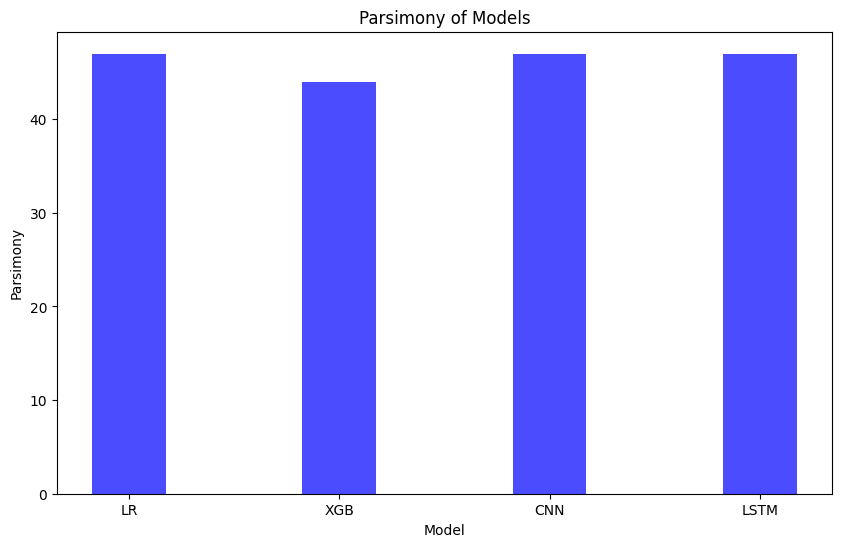

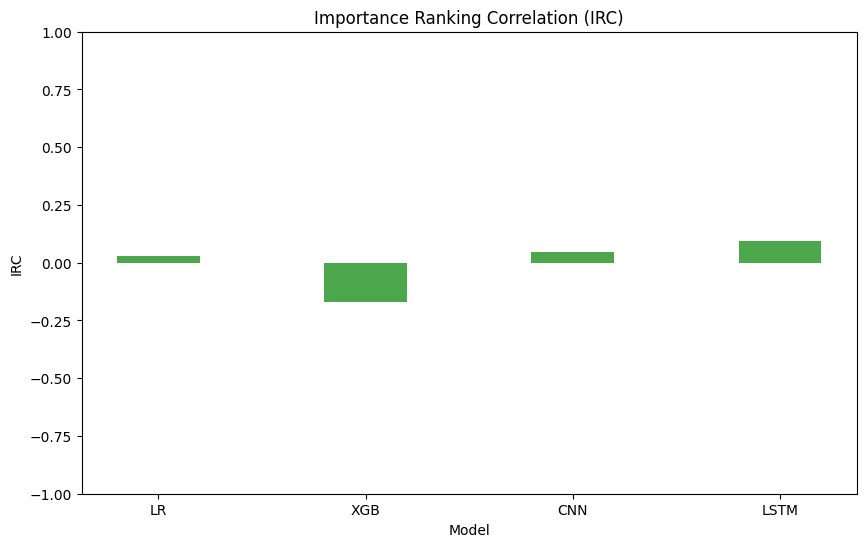

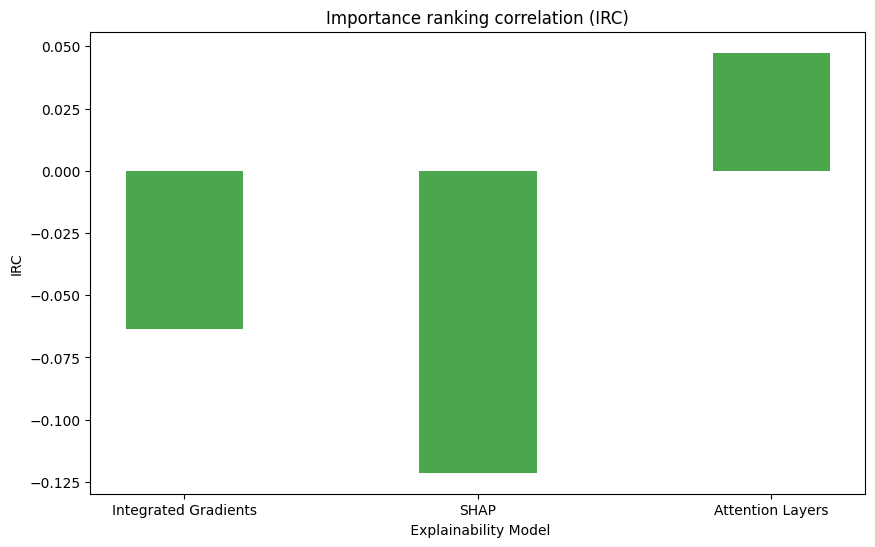

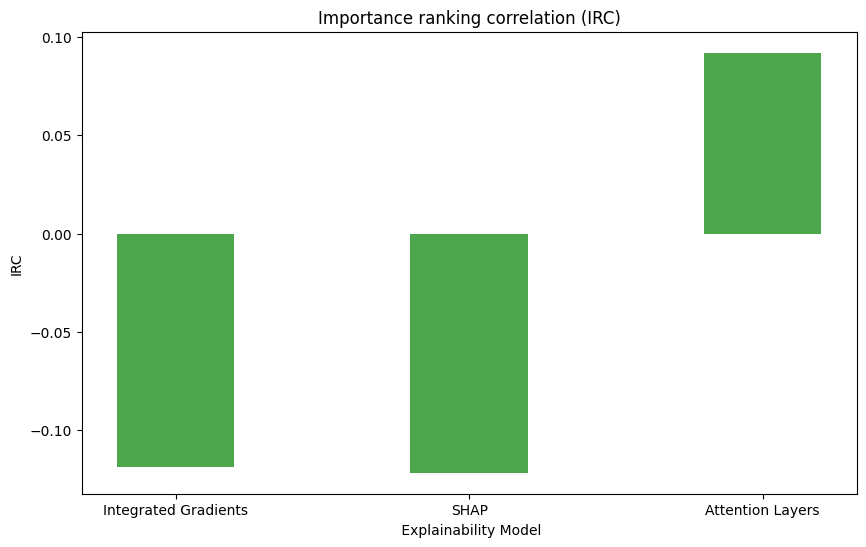

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns



FC_cnn_IG = [0.9967139727593104, 0.955567196875893, 0.5186446328221735, 0.8783693685112868, 0.9919754262310696, 0.9653538432231641, 0.917587389275169, 0.9549004667111154, 0.9986665396704448, 0.441637298790361, 0.12201162015430041, 0.4705686255833889, 0.9924516620630536, 0.9911420135250977, 0.6283931803028859, 0.1535384322316411, 0.1534193732736451, 0.1518239832364987, 0.1563006000571483, 0.009715210972473569, 0.02150204781407753, 0.02138298885608153, 0.9763548909419945, 0.9951423945137632, 0.9957376893037432, 0.9961424897609296, 0.3032193542242118, 0.9960472425945328, 0.992737403562244, 0.9942613582245928, 0.9488522716449186, 0.9903324126107248, 0.9909991427755024, 0.3024573768930374, 0.9776645394799505, 0.9927135917706448, 0.949138013144109, 0.9954043242213544, 0.9834031812553576, 0.24292789789503763, 0.6654681398228403, 0.5640060958186494, 0.9637108296028193, 0.9439470425754833, 0.8330317173064101, 0.996309172302124, 0.5953900371463949]
FC_cnn_SHAP = [0.9967615963425088, 0.9545671016287266, 0.5193589865701496, 0.8802743118392228, 0.9919992380226689, 0.9637584531860177, 0.9177540718163635, 0.9569959043718449, 0.9988570340032384, 0.44156586341556336, 0.12258310315268121, 0.4720925802457377, 0.9929040861034384, 0.9925945328126489, 0.6277026383465092, 0.1533241261072483, 0.1542765977712163, 0.15258596056767312, 0.15451471568720831, 0.009715210972473569, 0.021525859605676732, 0.02150204781407753, 0.9775692923135537, 0.9955471949709496, 0.995713877512144, 0.9951900180969616, 0.30302885989141826, 0.9962377369273264, 0.992737403562244, 0.9937851223926089, 0.947352128774169, 0.9906895894847129, 0.9912134488998953, 0.30302885989141826, 0.9771406800647681, 0.9925707210210496, 0.9473997523573674, 0.9963806076769216, 0.9818077912182113, 0.24338032193542242, 0.6677540718163635, 0.5669825697685494, 0.9629250404800457, 0.9418992284979522, 0.8339127535955805, 0.9954995713877512, 0.5968425564339461]
FC_cnn_AL = [0.9965949138013144, 0.954376607295933, 0.5174540432422136, 0.8776550147633108, 0.991903990856272, 0.9630202876464425, 0.916277740737213, 0.9558767501666825, 0.999166587294028, 0.4389227545480522, 0.12205924373749881, 0.4721163920373369, 0.9924516620630536, 0.9922135441470616, 0.628631298218878, 0.15370511477283552, 0.15434803314601392, 0.1518716068196971, 0.1555862463091723, 0.00969139918087437, 0.02145442423087913, 0.02162110677207353, 0.9768311267739784, 0.9951662063053625, 0.99642823126012, 0.9955710067625488, 0.30274311839222784, 0.9964044194685208, 0.9929040861034384, 0.9939041813506048, 0.9480188589389466, 0.9899038003619393, 0.9912134488998953, 0.30310029526621585, 0.9772597390227641, 0.992380226688256, 0.9470663872749786, 0.996309172302124, 0.9827602628821792, 0.24330888656062483, 0.6640632441184875, 0.5665063339365654, 0.9634488998952281, 0.941994475664349, 0.8300552433565102, 0.9961663015525288, 0.5953662253547957]

IRC_cnn_IG = -0.06359851988899166
IRC_cnn_SHAP = -0.12129972247918595
IRC_cnn_AL = 0.04740980573543016

FC_lstm_IG = [0.996904467092104, 0.956162491665873, 0.518573197447376, 0.8798695113820364, 0.9924754738546528, 0.9641394418516049, 0.916873035527193, 0.9558529383750833, 0.998928469378036, 0.4434469949519002, 0.12186874940470521, 0.4733069816172969, 0.9925230974378513, 0.9916896847318792, 0.6298456995904372, 0.1561815410991523, 0.1538956091056291, 0.1531574435660539, 0.1557767406419659, 0.00966758738927517, 0.02138298885608153, 0.02166873035527193, 0.9765691970663872, 0.9955710067625488, 0.9956662539289456, 0.995594818554148, 0.302290694351843, 0.9968092199257073, 0.9939756167254025, 0.9949280883893704, 0.9482569768549386, 0.9907848366511096, 0.9907848366511096, 0.3039813315553862, 0.9767596913991808, 0.9949757119725688, 0.9464710924849986, 0.9960948661777312, 0.9827126392989809, 0.2430707686446328, 0.6643727974092771, 0.5986046290122868, 0.9962139251357273, 0.9957853128869416, 0.8315315744356605, 0.9959281836365368, 0.5971521097247356]
FC_lstm_SHAP = [0.9971902085912944, 0.9553290789599009, 0.5181445851985903, 0.877321649680922, 0.992618344604248, 0.9640203828936089, 0.9160158110296218, 0.9563529859986666, 0.9989999047528336, 0.44166111058196017, 0.12253547956948281, 0.4729498047433089, 0.992618344604248, 0.9918087436898753, 0.6321078197923612, 0.1563482236403467, 0.1532765025240499, 0.1510143823221259, 0.1551338222687875, 0.00969139918087437, 0.02145442423087913, 0.02145442423087913, 0.9774740451471569, 0.9952614534717592, 0.9960234308029337, 0.9961663015525288, 0.30276693018382705, 0.9960234308029337, 0.994999523764168, 0.9954043242213544, 0.9467806457757881, 0.9899276121535384, 0.9909991427755024, 0.30293361272502145, 0.9775216687303553, 0.9951662063053625, 0.9486855891037241, 0.9958091246785408, 0.9823316506333937, 0.24290408610343842, 0.6657062577388323, 0.5953186017715973, 0.9961186779693304, 0.9957615010953424, 0.8304600438136965, 0.9959996190113344, 0.5946280598152205]
FC_lstm_AL = [0.9970473378416992, 0.9537336889227546, 0.5190732450709591, 0.8784169920944852, 0.992737403562244, 0.9647109248499857, 0.9173016477759787, 0.955567196875893, 0.9987617868368416, 0.43932755500523857, 0.12186874940470521, 0.4719973330793409, 0.9921897323554624, 0.9915706257738832, 0.6322506905419564, 0.1558719878083627, 0.1539908562720259, 0.1517763596533003, 0.1559910467663587, 0.00969139918087437, 0.02143061243927993, 0.02154967139727593, 0.9761167730260025, 0.9954043242213544, 0.9956900657205449, 0.9960948661777312, 0.30224307076864465, 0.9962853605105249, 0.9950471473473664, 0.9950709591389656, 0.9501857319744738, 0.9900704829031336, 0.9906895894847129, 0.3032193542242118, 0.9772597390227641, 0.9948328412229737, 0.9477331174397562, 0.996071054386132, 0.9821411563006001, 0.24347556910181922, 0.6660396228212211, 0.5958424611867797, 0.9957376893037432, 0.99523764168016, 0.8328888465568149, 0.996071054386132, 0.5945090008572245]

IRC_lstm_IG = -0.11875578168362629
IRC_lstm_SHAP = -0.12153098982423681
IRC_lstm_AL = 0.09192876965772433

parsimony_cnn = 47
functional_complexity_cnn = [0.9965949138013144, 0.954376607295933, 0.5174540432422136, 0.8776550147633108, 0.991903990856272, 0.9630202876464425, 0.916277740737213, 0.9558767501666825, 0.999166587294028, 0.4389227545480522, 0.12205924373749881, 0.4721163920373369, 0.9924516620630536, 0.9922135441470616, 0.628631298218878, 0.15370511477283552, 0.15434803314601392, 0.1518716068196971, 0.1555862463091723, 0.00969139918087437, 0.02145442423087913, 0.02162110677207353, 0.9768311267739784, 0.9951662063053625, 0.99642823126012, 0.9955710067625488, 0.30274311839222784, 0.9964044194685208, 0.9929040861034384, 0.9939041813506048, 0.9480188589389466, 0.9899038003619393, 0.9912134488998953, 0.30310029526621585, 0.9772597390227641, 0.992380226688256, 0.9470663872749786, 0.996309172302124, 0.9827602628821792, 0.24330888656062483, 0.6640632441184875, 0.5665063339365654, 0.9634488998952281, 0.941994475664349, 0.8300552433565102, 0.9961663015525288, 0.5953662253547957]
irc_cnn = 0.04740980573543016
lod_cnn = 3.6644361302207638
parsimony_lstm = 47
functional_complexity_lstm = [0.9970473378416992, 0.9537336889227546, 0.5190732450709591, 0.8784169920944852, 0.992737403562244, 0.9647109248499857, 0.9173016477759787, 0.955567196875893, 0.9987617868368416, 0.43932755500523857, 0.12186874940470521, 0.4719973330793409, 0.9921897323554624, 0.9915706257738832, 0.6322506905419564, 0.1558719878083627, 0.1539908562720259, 0.1517763596533003, 0.1559910467663587, 0.00969139918087437, 0.02143061243927993, 0.02154967139727593, 0.9761167730260025, 0.9954043242213544, 0.9956900657205449, 0.9960948661777312, 0.30224307076864465, 0.9962853605105249, 0.9950471473473664, 0.9950709591389656, 0.9501857319744738, 0.9900704829031336, 0.9906895894847129, 0.3032193542242118, 0.9772597390227641, 0.9948328412229737, 0.9477331174397562, 0.996071054386132, 0.9821411563006001, 0.24347556910181922, 0.6660396228212211, 0.5958424611867797, 0.9957376893037432, 0.99523764168016, 0.8328888465568149, 0.996071054386132, 0.5945090008572245]
irc_lstm = 0.09192876965772433
lod_lstm = 3.66443612296937


parsimony_LR = 47
functional_complexity_LR = [0.9964996666349176, 0.9548766549195161, 0.5182636441565863, 0.8806076769216116, 0.9926421563958472, 0.9628774168968474, 0.9188494142299266, 0.9546623487951233, 0.9985236689208496, 0.4430898180779122, 0.12210686732069721, 0.4693542242118297, 0.992023049814268, 0.9915706257738832, 0.63065530050481, 0.1558243642251643, 0.1537765501476331, 0.1517763596533003, 0.1557291170587675, 0.00969139918087437, 0.02162110677207353, 0.02150204781407753, 0.9755929136108201, 0.9956900657205449, 0.99583293647014, 0.99583293647014, 0.30376702543099343, 0.9959996190113344, 0.9950471473473664, 0.9958567482617392, 0.9469473283169826, 0.9901657300695305, 0.9915468139822841, 0.30343366034860464, 0.9773073626059625, 0.995118582722164, 0.946399657110201, 0.996071054386132, 0.9816887322602152, 0.24292789789503763, 0.6647061624916659, 0.5947947423564149, 0.9959281836365368, 0.9963806076769216, 0.8341032479283741, 0.9961663015525288, 0.5952947899799981]
irc_LR = 0.02775208140610546
lod_LR = 60.241181927316134
parsimony_XGB = 44
functional_complexity_XGB = [0.9887132107819793, 0.8556767311172493, 0.5095723402228783, 0.8517001619201828, 0.9366606343461282, 0.9414944280407658, 0.7964806172016382, 0.9200161920182874, 0.9735689113248881, 0.4410181922087818, 0.122202114487094, 0.4724259453281265, 0.8330555290980093, 0.9117058767501667, 0.6067006381560148, 0.09196113915611011, 0.021525859605676732, 0.0, 0.07538813220306696, 0.0036670159062767885, 0.0, 0.0, 0.3596294885227164, 0.4097533098390323, 0.1546337746452043, 0.030121916372987903, 0.01254881417277836, 0.5265263358415088, 0.49342794551862085, 0.09710448614153729, 0.35691494428040765, 0.5693875607200686, 0.25814363272692636, 0.27528812267835034, 0.05902943137441661, 0.126369178016954, 0.36174873797504525, 0.3164825221449662, 0.23130774359462805, 0.2191399180874369, 0.1612534527097819, 0.04388513191732546, 0.5906753024097533, 0.14208496047242594, 0.06762548814172778, 0.06576816839699019, 0.06324411848747499]
irc_XGB = -0.17127327511317497
lod_XGB = 51.03920062069938


# Plot Parsimony
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = ['LR', 'XGB', 'CNN', 'LSTM']
parsimony_values = [parsimony_LR, parsimony_XGB, parsimony_cnn, parsimony_lstm]

plt.bar(index, parsimony_values, bar_width, alpha=0.7, color='b')
plt.xlabel('Model')
plt.ylabel('Parsimony')
plt.title('Parsimony of Models')
plt.show()

# # Plot Functional Complexity ML
# plt.figure(figsize=(10, 6))
# index = range(len(functional_complexity_LR))

# plt.plot(index, functional_complexity_LR, label='LR', marker='o')
# plt.plot(index, functional_complexity_XGB, label='XGB', marker='x')
# plt.xlabel('Feature Index')
# plt.ylabel('Number of Changed Predictions')
# plt.title('Functional Complexity')
# plt.legend()
# plt.show()

# # Plot Functional Complexity DL
# plt.figure(figsize=(10, 6))
# index = range(len(functional_complexity_cnn))

# plt.plot(index, functional_complexity_cnn, label='CNN', marker='o')
# plt.plot(index, functional_complexity_lstm, label='LSTM', marker='x')
# plt.xlabel('Feature Index')
# plt.ylabel('Number of Changed Predictions')
# plt.title('Functional Complexity')
# plt.legend()
# plt.show()

# Plot IRC
plt.figure(figsize=(10, 6))
irc_values = [irc_LR, irc_XGB, irc_cnn, irc_lstm]

bar_width = 0.4  # Adjusted bar width
plt.bar(['LR', 'XGB', 'CNN', 'LSTM'], irc_values, bar_width, alpha=0.7, color='g')

# Set y-axis limits to scale between -1 and 1
plt.ylim(-1, 1)

plt.xlabel('Model')
plt.ylabel('IRC')
plt.title('Importance Ranking Correlation (IRC)')
plt.show()

# Plot IRC CNN
plt.figure(figsize=(10, 6))
irc_values = [IRC_cnn_IG, IRC_cnn_SHAP, IRC_cnn_AL]

plt.bar(['Integrated Gradients', 'SHAP', 'Attention Layers'], irc_values, bar_width, alpha=0.7, color='g')
plt.xlabel(' Explainability Model')
plt.ylabel('IRC')
plt.title('Importance ranking correlation (IRC)')
plt.show()

# Plot IRC LSTM
plt.figure(figsize=(10, 6))
irc_values = [IRC_lstm_IG, IRC_lstm_SHAP, IRC_lstm_AL]

plt.bar(['Integrated Gradients', 'SHAP', 'Attention Layers'], irc_values, bar_width, alpha=0.7, color='g')
plt.xlabel(' Explainability Model')
plt.ylabel('IRC')
plt.title('Importance ranking correlation (IRC)')
plt.show()

# # Plot LOD
# plt.figure(figsize=(10, 6))
# lod_values = [lod_LR, lod_XGB, lod_cnn, lod_lstm]

# plt.bar(['LR', 'XGB', 'CNN', 'LSTM'], lod_values, bar_width, alpha=0.7, color='r')
# plt.xlabel('Model')
# plt.ylabel('LOD@10')
# plt.title('Level of disagreement (LOD@10)')
# plt.show()

Length of CNN data: 47
Length of LSTM data: 47
Length of predictors: 47


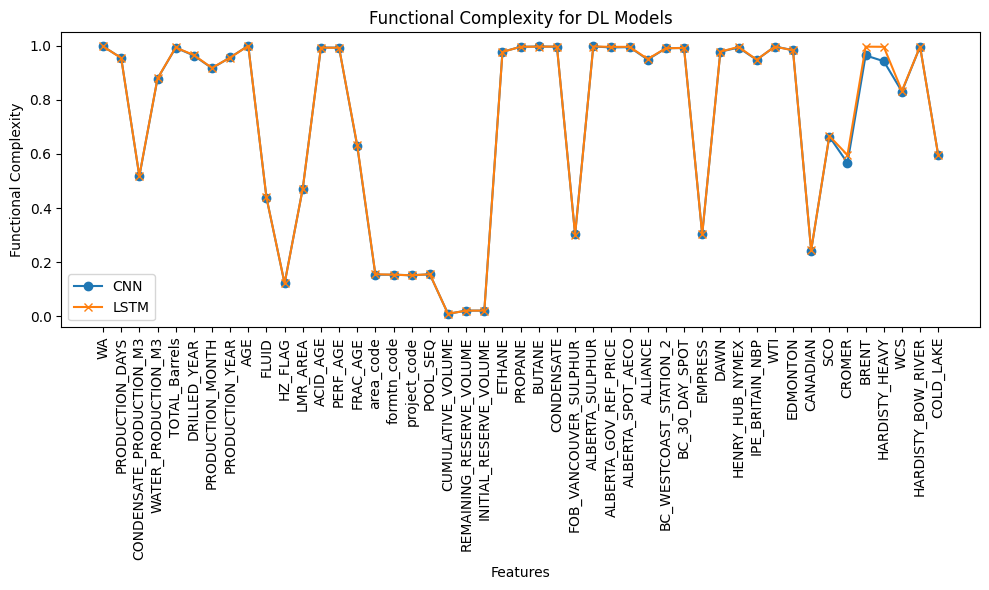

In [94]:
feature_names = ['WA','PRODUCTION_DAYS', 'CONDENSATE_PRODUCTION_M3', 'WATER_PRODUCTION_M3',
       'TOTAL_Barrels', 'DRILLED_YEAR', 'PRODUCTION_MONTH', 'PRODUCTION_YEAR',
       'AGE', 'FLUID', 'HZ_FLAG', 'LMR_AREA', 'ACID_AGE', 'PERF_AGE',
       'FRAC_AGE', 'area_code', 'formtn_code', 'project_code', 'POOL_SEQ',
       'CUMULATIVE_VOLUME', 'REMAINING_RESERVE_VOLUME',
       'INITIAL_RESERVE_VOLUME', 'ETHANE', 'PROPANE', 'BUTANE', 'CONDENSATE',
       'FOB_VANCOUVER_SULPHUR', 'ALBERTA_SULPHUR', 'ALBERTA_GOV_REF_PRICE',
       'ALBERTA_SPOT_AECO', 'ALLIANCE', 'BC_WESTCOAST_STATION_2',
       'BC_30_DAY_SPOT', 'EMPRESS', 'DAWN', 'HENRY_HUB_NYMEX',
       'IPE_BRITAIN_NBP', 'WTI', 'EDMONTON', 'CANADIAN', 'SCO', 'CROMER',
       'BRENT', 'HARDISTY_HEAVY', 'WCS', 'HARDISTY_BOW_RIVER', 'COLD_LAKE']

# # Ensure the number of features matches the length of your data
# # assert len(functional_complexity_cnn) == len(rul_predictors)
# # assert len(functional_complexity_lstm) == len(rul_predictors)

# # Plot Functional Complexity
# plt.figure(figsize=(10, 6))
# index = range(len(functional_complexity_cnn))

# plt.plot(index, functional_complexity_cnn, label='CNN', marker='o')
# plt.plot(index, functional_complexity_lstm, label='LSTM', marker='x')

# # Set x-axis labels to feature names
# plt.xticks(index, rul_predictors)

# plt.xlabel('Features')
# plt.ylabel('Number of Changed Predictions')
# plt.title('Functional Complexity')
# plt.legend()
# plt.show()





# Check lengths of the data lists
len_cnn = len(functional_complexity_cnn)
len_lstm = len(functional_complexity_lstm)
len_predictors = len(feature_names)

print(f"Length of CNN data: {len_cnn}")
print(f"Length of LSTM data: {len_lstm}")
print(f"Length of predictors: {len_predictors}")

# Ensure the lengths of the data lists are the same
min_length = min(len_cnn, len_lstm, len_predictors)

functional_complexity_cnn = functional_complexity_cnn[:min_length]
functional_complexity_lstm = functional_complexity_lstm[:min_length]
feature_names = feature_names[:min_length]

plt.figure(figsize=(10, 6))
index = range(len(functional_complexity_cnn))

plt.plot(index, functional_complexity_cnn, label='CNN', marker='o')
plt.plot(index, functional_complexity_lstm, label='LSTM', marker='x')

# Set x-axis labels to feature names
plt.xticks(index, feature_names, rotation=90)

plt.xlabel('Features')
plt.ylabel('Functional Complexity')
plt.title('Functional Complexity for DL Models')
plt.legend()
plt.tight_layout()
plt.show()

In [92]:
# plt.figure(figsize=(10, 6))
# index = range(len(functional_complexity_cnn))

# plt.plot(index, FC_cnn_IG, label='Integrated Gradients', marker='o')
# plt.plot(index, FC_cnn_SHAP, label='SHAP', marker='x')
# plt.plot(index, FC_cnn_AL, label='Attention Layers', marker='*')

# # Set x-axis labels to feature names
# plt.xticks(index, feature_names, rotation=90)

# plt.xlabel('Features')
# plt.ylabel('Functional Complexity')
# plt.title('Functional Complexity for CNN')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [93]:
# plt.figure(figsize=(10, 6))
# index = range(len(functional_complexity_cnn))

# plt.plot(index, FC_lstm_IG, label='Integrated Gradients', marker='o')
# plt.plot(index, FC_lstm_SHAP, label='SHAP', marker='x')
# plt.plot(index, FC_lstm_AL, label='Attention Layers', marker='*')

# # Set x-axis labels to feature names
# plt.xticks(index, feature_names, rotation=90)

# plt.xlabel('Features')
# plt.ylabel('Functional Complexity')
# plt.title('Functional Complexity for LSTM')
# plt.legend()
# plt.tight_layout()
# plt.show()

Length of LR data: 47
Length of XGB data: 47
Length of predictors: 47


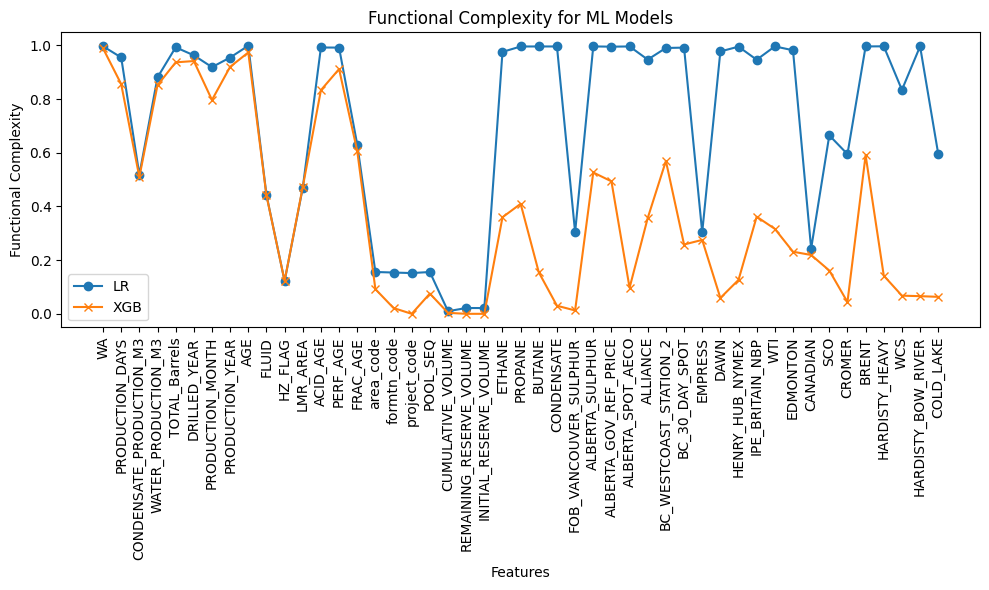

In [95]:
# Check lengths of the data lists
len_LR = len(functional_complexity_LR)
len_XGB = len(functional_complexity_XGB)

print(f"Length of LR data: {len_LR}")
print(f"Length of XGB data: {len_XGB}")
print(f"Length of predictors: {len_predictors}")

# Ensure the lengths of the data lists are the same
minimum_length = min(len_LR, len_XGB, len_predictors)

functional_complexity_LR = functional_complexity_LR[:minimum_length]
functional_complexity_XGB = functional_complexity_XGB[:minimum_length]
rul_predictorsML = feature_names[:minimum_length]

plt.figure(figsize=(10, 6))
index = range(len(functional_complexity_LR))

plt.plot(index, functional_complexity_LR, label='LR', marker='o')
plt.plot(index, functional_complexity_XGB, label='XGB', marker='x')

# Set x-axis labels to feature names
plt.xticks(index, rul_predictorsML, rotation=90)

plt.xlabel('Features')
plt.ylabel('Functional Complexity')
plt.title('Functional Complexity for ML Models')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
rul_predictors

Index(['PRODUCTION_DAYS', 'CONDENSATE_PRODUCTION_M3', 'WATER_PRODUCTION_M3',
       'TOTAL_Barrels', 'DRILLED_YEAR', 'PRODUCTION_MONTH', 'PRODUCTION_YEAR',
       'AGE', 'FLUID', 'HZ_FLAG', 'LMR_AREA', 'ACID_AGE', 'PERF_AGE',
       'FRAC_AGE', 'area_code', 'formtn_code', 'project_code', 'POOL_SEQ',
       'CUMULATIVE_VOLUME', 'REMAINING_RESERVE_VOLUME',
       'INITIAL_RESERVE_VOLUME', 'ETHANE', 'PROPANE', 'BUTANE', 'CONDENSATE',
       'FOB_VANCOUVER_SULPHUR', 'ALBERTA_SULPHUR', 'ALBERTA_GOV_REF_PRICE',
       'ALBERTA_SPOT_AECO', 'ALLIANCE', 'BC_WESTCOAST_STATION_2',
       'BC_30_DAY_SPOT', 'EMPRESS', 'DAWN', 'HENRY_HUB_NYMEX',
       'IPE_BRITAIN_NBP', 'WTI', 'EDMONTON', 'CANADIAN', 'SCO', 'CROMER',
       'BRENT', 'HARDISTY_HEAVY', 'WCS', 'HARDISTY_BOW_RIVER', 'COLD_LAKE'],
      dtype='object')

# ***************************************************************************

Key Adaptations:
Integrated Gradients: Used for calculating feature importances for CNN and LSTM models.
Functional Complexity Calculation: Adapted to count the number of prediction changes when features are permuted, suitable for tensor data.
Device Management: Handled tensor operations using PyTorch, ensuring the use of GPUs if available.

In [19]:
# Make sure to use the same model type for both the black-box model and the explainability model, 
# but configure the explainability model to utilize its built-in explainability features (such as SHAP values for XGBoost)




import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_lod(black_box_model, explainability_model, X):
    # Generate predictions from both models
    black_box_predictions = black_box_model.predict(X)
    explainability_predictions = explainability_model.predict(X)
    
    # Calculate the percentage of similar predictions
    similar_predictions = (black_box_predictions == explainability_predictions).sum()
    total_predictions = len(black_box_predictions)
    
    lod = (total_predictions - similar_predictions) / total_predictions * 100  # Percentage of disagreement
    return lod

class Faithfulness():
    def __init__(self, cls_method, dt_train_named_original, model_effects, cls=None):
        self.cls = cls
        self.cls_method = cls_method
        self.dt_train_named_original = dt_train_named_original
        self.model_effects = model_effects
    
    def calculate(self, xai_importances=None, model_explainer=None):
        feature_importance = pd.DataFrame()
        feature_importance['variable'] = self.dt_train_named_original.columns
        perturbation_importance = self.model_effects
        feature_importance['importances'] = perturbation_importance
        
        if self.cls_method in ['RF', 'XGB']:
            sample = shap.sample(self.dt_train_named_original, 1000)
            explainer = shap.TreeExplainer(self.cls, sample)
            shap_values = explainer.shap_values(sample, check_additivity=False)
            if self.cls_method == 'XGB':
                vals = np.abs(shap_values).mean(0)
            else:
                vals = np.abs(shap_values[0]).mean(0)
            
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = vals
        
        elif self.cls_method == 'LR':
            coeffs = np.abs(self.cls.coef_).flatten()
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = coeffs
        
        elif self.cls_method == 'GLRM':
            feature_importances = []
            for i in range(len(self.dt_train_named_original.columns)):
                feature_importance_value = abs(model_explainer[(model_explainer['rule'].str.contains(self.dt_train_named_original.columns[i]))]['coefficient']).sum()
                feature_importances.append(feature_importance_value)
            xai_importances = pd.DataFrame()
            xai_importances['variable'] = self.dt_train_named_original.columns
            xai_importances['coefficients'] = feature_importances
        
        resulting_frame = pd.concat([xai_importances, feature_importance], join='inner', axis=1)
        resulting_frame.sort_values(by='importances', ascending=False, inplace=True)
        
        coef, p = spearmanr(resulting_frame['coefficients'], resulting_frame['importances'])
        
        return coef, resulting_frame
    
    def calculate_parsimony(self):
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_parsimony(xai_importances)
    
    def calculate_functional_complexity(self):
        return calculate_functional_complexity(self.cls, self.dt_train_named_original, self.model_effects)
    
    def calculate_irc(self):
        perm_importances = self.model_effects
        xai_importances = self.calculate()[1]['coefficients']
        return calculate_irc(perm_importances, xai_importances)
    
    def calculate_lod(self, explainability_model, X):
        return calculate_lod(self.cls, explainability_model, X)

# Example usage:

# Train and evaluate models
# ML: LR and XGB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# # Prepare the data
# X_train = pd.DataFrame({
#     'feature1': [1, 2, 3, 4, 5],
#     'feature2': [5, 4, 3, 2, 1],
#     'feature3': [1, 3, 5, 7, 9]
# })
# y_train = np.array([1, 2, 3, 4, 5])

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

xgb_model = DecisionTreeRegressor(random_state=42)  # Using DecisionTreeRegressor for simplicity
xgb_model.fit(X_train, y_train)

# Explainability model (for example purposes, using the same DecisionTreeRegressor)
explainability_model = DecisionTreeRegressor(random_state=42)
explainability_model.fit(X_train, y_train)

# Prepare dummy data for Faithfulness calculation
model_effects = np.random.rand(X_train.shape[1])

# Calculate faithfulness for Linear Regression model
faithfulness_lr = Faithfulness('LR', pd.DataFrame(X_train, columns=X_train.columns), model_effects, lr_model)
coef_lr, resulting_frame_lr = faithfulness_lr.calculate()

# Calculate faithfulness for Decision Tree model
faithfulness_xgb = Faithfulness('XGB', pd.DataFrame(X_train, columns=X_train.columns), model_effects, xgb_model)
coef_xgb, resulting_frame_xgb = faithfulness_xgb.calculate()

# Calculate parsimony, functional complexity, IRC, and LOD for LR model
parsimony_lr = faithfulness_lr.calculate_parsimony()
functional_complexity_lr = faithfulness_lr.calculate_functional_complexity()
irc_lr = faithfulness_lr.calculate_irc()
lod_lr = faithfulness_lr.calculate_lod(explainability_model, X_train)

print(f'Linear Regression Parsimony: {parsimony_lr}')
print(f'Linear Regression Functional Complexity: {functional_complexity_lr}')
print(f'Linear Regression IRC: {irc_lr}')
print(f'Linear Regression LOD: {lod_lr}')


In [15]:
# # for the Level of Disagreement (LOD) metric, 
# # we need to compare the predictions of the original black-box model with 
# # a different model that has built-in explainability features.
# # This is to measure how well the explainable model approximates the black-box model's predictions.

# # Implementing LOD with SHAP Values
# # SHAP values are used to interpret the predictions of a black-box model. 
# # How to incorporate SHAP values into LOD calculation:


# # Train the XGB model
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# import numpy as np
# import pandas as pd

# # Example data
# X, y = pd.DataFrame({
#     'feature1': [1, 2, 3, 4, 5],
#     'feature2': [5, 4, 3, 2, 1],
#     'feature3': [1, 3, 5, 7, 9]
# }), np.array([1, 2, 3, 4, 5])

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train XGBoost model
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# xgb_model.fit(X_train, y_train)

# # Explain the XGB model using SHAP
# import shap

# # Initialize SHAP explainer
# explainer = shap.Explainer(xgb_model, X_train)
# shap_values = explainer(X_test)

# # Get SHAP values for the test set
# shap_test_values = shap_values.values

# # Calculate SHAP predictions by summing SHAP values and adding the base value
# shap_predictions = shap_test_values.sum(axis=1) + explainer.expected_value

# # Calculate LOD
# def calculate_lod(black_box_predictions, explainability_predictions):
#     similar_predictions = np.sum(np.isclose(black_box_predictions, explainability_predictions, atol=0.1))
#     total_predictions = len(black_box_predictions)
    
#     lod = (total_predictions - similar_predictions) / total_predictions * 100  # Percentage of disagreement
#     return lod

# # Get predictions from the XGBoost model for the test set
# xgb_predictions = xgb_model.predict(X_test)

# # Calculate LOD
# lod = calculate_lod(xgb_predictions, shap_predictions)
# print(f'Level of Disagreement (LOD): {lod:.2f}%')


Level of Disagreement (LOD): 0.00%


Explanation
XGBoost Model: Trained on the original training data to make predictions.
SHAP Explainer: Used to interpret the XGBoost model’s predictions and generate SHAP values.
SHAP Predictions: Sum of SHAP values and the expected value (base value).
LOD Calculation: Compares the predictions from the XGBoost model and the SHAP-based predictions. We use np.isclose with a tolerance to account for small numerical differences.
By using SHAP values, we leverage an explainability model that inherently provides insights into feature contributions for each prediction. The LOD metric here helps us understand how closely the SHAP explanations match the original model's predictions.